START OF THE FINAL PROJECT

All of the import statements

In [1]:
import pandas as pd
import transformers
from torch import torch_version
from torch import nn
import torch
import lyricsgenius
from tqdm import tqdm
import numpy as np

1)LOAD THE DATASET

In [2]:
import pandas as pd
import string
import re 
# from config import CONFIG



class PREPROCESS:
    def __init__(self) -> None:
        df = pd.read_csv("output_csv_file.csv")
        df["prepText"] = df["Lyrics"].apply(self.cleanString)
        df = df[["Artist", "Title", "prepText","Label"]]
        # save the file 
        df.to_csv("preprocessed_songs_gram.csv", index=False)
    
    def cleanString(self,sentence):
        sentence = sentence.translate(str.maketrans("","", string.punctuation)).strip().lower()
        sentence = re.sub(r"https?://\s+", "", sentence)
        sentence = re.sub(r"\b\d+\b",  "", sentence)
        sentence = re.sub(r" +"," ",sentence).replace("\n", " ").replace("\r", "").replace("\r\n", "")
        sentence = re.sub("\s+", " ", sentence)
        return sentence    




In [39]:
PREPROCESS()


In [44]:
from sentence_transformers import SentenceTransformer

import os
import numpy as np
from tqdm import tqdm
# import faiss
class findEmbedding:
    def __init__(self) -> None:
        self.df = pd.read_csv("preprocessed_songs_gram.csv")
        self.model = SentenceTransformer('all-MiniLM-L6-v2')
        embeddings = self.computeEmbeddings()
        if not os.path.isdir("results"):
            os.mkdir("results")
        PATH = os.path.join("embedding.npy")
        with open( PATH, "wb") as fp:
            np.save(fp, embeddings)

    def computeEmbeddings(self):
        sentences = self.df["prepText"].values
        embeddings = []
        for sentence in tqdm(sentences):
            embedding = self.model.encode(sentence)
            embeddings.append(embedding)
        return np.array(embeddings)

In [45]:
findEmbedding()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 773/773 [00:42<00:00, 18.14it/s]


In [8]:
import faiss
class recmmSystem:
    def __init__(self) -> None:
        self.model = SentenceTransformer('all-MiniLM-L6-v2')
        self.df = pd.read_csv("preprocessed_songs.csv")
        PATH = os.path.join( "embedding.npy")
        embeddings = np.load(PATH)
        dimension = embeddings.shape[1]
        quantize = faiss.IndexFlatL2(dimension)
        self.index = faiss.IndexIVFFlat(quantize, dimension, 50)

        if not self.index.is_trained:
            print(1)
            self.index.train(embeddings)
        
        if self.index.is_trained:
            print(0)
            self.index.add(embeddings)

        print("Total Number of embeddings index {}".format(self.index.ntotal))
    
    def nearestNeighbour(self, query, k):
        queryEmbeddings = self.model.encode([query])
        D, I = self.index.search(queryEmbeddings, k)
        artist_songs = dict()
        allRelatable = self.df.iloc[I[0]]
        for index, rows in allRelatable.iterrows():
            print(rows["artist"])
            artist_songs[rows["artist"]] = rows["song"]
        
        print("Query: ", query)
        print(artist_songs)
findEmbedding()
recmmSystem()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 9/9 [00:00<00:00, 40.57it/s]


NameError: name 'faiss' is not defined

In [1]:
from pyechonest import catalog
cat = catalog.Catalog('CACNYVZ1332EB0BA9D')
cat.read()

TabError: inconsistent use of tabs and spaces in indentation (catalog.py, line 327)

In [5]:
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms

class fs_model(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(fs_model, self).__init__()
        self.relu = nn.ReLU()  
        self.sigmoid = nn.Sigmoid();
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim) 

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        # x = torch.round(x)
        return x


In [3]:
import json,os
i = 0
labels = []
for filename in os.listdir("results"):
    if i>6:
        break
    i+=1
    with open(f"results/{filename}","r") as file:
        data = json.load(file)
        for song in data:
            labels.append(song["Label"])
labels = [element.rstrip("\n") for element in labels] 
labels = labels[:251]

labels = [int(element) for element in labels]
print(labels)    


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]


/var/folders/bv/jp3prgcx78l1rxwtfc2pqmg40000gn/T/ipykernel_70001/2865065522.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  user_tensors_tensor = torch.tensor(user_embeddings, dtype=torch.float32)
[I 2024-05-08 09:52:48,360] A new study created in memory with name: no-name-13ff6b48-840c-42a8-b737-b851336b6e58
/var/folders/bv/jp3prgcx78l1rxwtfc2pqmg40000gn/T/ipykernel_70001/2865065522.py:75: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-6, 1e-1)
[I 2024-05-08 09:52:48,380] Trial 0 finished with value: 1700.0 and parameters: {'hidden_dim': 133, 'lr': 0.00014449865317097115, 'batch_size': 64}. Best is trial 0 with value: 1700.0.
[I 2024-0

1
test loss: fs_model(
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=385, out_features=133, bias=True)
  (fc2): Linear(in_features=133, out_features=133, bias=True)
  (fc3): Linear(in_features=133, out_features=1, bias=True)
)
Test loss is  0.69
2
test loss: fs_model(
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=385, out_features=133, bias=True)
  (fc2): Linear(in_features=133, out_features=133, bias=True)
  (fc3): Linear(in_features=133, out_features=1, bias=True)
)
Test loss is  0.69
1
test loss: fs_model(
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=385, out_features=133, bias=True)
  (fc2): Linear(in_features=133, out_features=133, bias=True)
  (fc3): Linear(in_features=133, out_features=1, bias=True)
)
Test loss is  0.69
1
test loss: fs_model(
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=385, out_features=133, bias=True)
  (fc2): Linear(in_features=133, out_features=133, bias=True)
  (fc3): 

[I 2024-05-08 09:52:48,579] Trial 22 finished with value: 1900.0 and parameters: {'hidden_dim': 187, 'lr': 1.4282393379539978e-05, 'batch_size': 128}. Best is trial 14 with value: 2800.0.
[I 2024-05-08 09:52:48,590] Trial 23 finished with value: 2300.0 and parameters: {'hidden_dim': 158, 'lr': 5.62143607048184e-05, 'batch_size': 128}. Best is trial 14 with value: 2800.0.
[I 2024-05-08 09:52:48,601] Trial 24 finished with value: 2000.0 and parameters: {'hidden_dim': 190, 'lr': 2.3739285344721025e-06, 'batch_size': 128}. Best is trial 14 with value: 2800.0.
[I 2024-05-08 09:52:48,611] Trial 25 finished with value: 2100.0 and parameters: {'hidden_dim': 180, 'lr': 3.1947019555202026e-05, 'batch_size': 128}. Best is trial 14 with value: 2800.0.
[I 2024-05-08 09:52:48,621] Trial 26 finished with value: 1700.0 and parameters: {'hidden_dim': 200, 'lr': 7.180983138548566e-06, 'batch_size': 128}. Best is trial 14 with value: 2800.0.
[I 2024-05-08 09:52:48,632] Trial 27 finished with value: 2300.

1
test loss: fs_model(
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=385, out_features=133, bias=True)
  (fc2): Linear(in_features=133, out_features=133, bias=True)
  (fc3): Linear(in_features=133, out_features=1, bias=True)
)
Test loss is  0.69
1
test loss: fs_model(
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=385, out_features=133, bias=True)
  (fc2): Linear(in_features=133, out_features=133, bias=True)
  (fc3): Linear(in_features=133, out_features=1, bias=True)
)
Test loss is  0.69
1
test loss: fs_model(
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=385, out_features=133, bias=True)
  (fc2): Linear(in_features=133, out_features=133, bias=True)
  (fc3): Linear(in_features=133, out_features=1, bias=True)
)
Test loss is  0.69
1
test loss: fs_model(
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=385, out_features=133, bias=True)
  (fc2): Linear(in_features=133, out_features=133, bias=True)
  (fc3): 

[I 2024-05-08 09:52:48,799] Trial 41 finished with value: 2400.0 and parameters: {'hidden_dim': 62, 'lr': 1.094735615566358e-06, 'batch_size': 128}. Best is trial 14 with value: 2800.0.
[I 2024-05-08 09:52:48,809] Trial 42 finished with value: 2000.0 and parameters: {'hidden_dim': 86, 'lr': 1.0896729827253937e-06, 'batch_size': 128}. Best is trial 14 with value: 2800.0.
[I 2024-05-08 09:52:48,821] Trial 43 finished with value: 2500.0 and parameters: {'hidden_dim': 98, 'lr': 1.6996529980011083e-06, 'batch_size': 128}. Best is trial 14 with value: 2800.0.
[I 2024-05-08 09:52:48,831] Trial 44 finished with value: 2200.0 and parameters: {'hidden_dim': 74, 'lr': 4.5587893404322385e-06, 'batch_size': 128}. Best is trial 14 with value: 2800.0.
[I 2024-05-08 09:52:48,845] Trial 45 finished with value: 2600.0 and parameters: {'hidden_dim': 151, 'lr': 2.9461184543708466e-06, 'batch_size': 128}. Best is trial 14 with value: 2800.0.
[I 2024-05-08 09:52:48,860] Trial 46 finished with value: 1220.0 

1
test loss: fs_model(
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=385, out_features=133, bias=True)
  (fc2): Linear(in_features=133, out_features=133, bias=True)
  (fc3): Linear(in_features=133, out_features=1, bias=True)
)
Test loss is  0.69
1
test loss: fs_model(
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=385, out_features=133, bias=True)
  (fc2): Linear(in_features=133, out_features=133, bias=True)
  (fc3): Linear(in_features=133, out_features=1, bias=True)
)
Test loss is  0.69
1
test loss: fs_model(
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=385, out_features=133, bias=True)
  (fc2): Linear(in_features=133, out_features=133, bias=True)
  (fc3): Linear(in_features=133, out_features=1, bias=True)
)
Test loss is  0.69
1
test loss: fs_model(
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=385, out_features=133, bias=True)
  (fc2): Linear(in_features=133, out_features=133, bias=True)
  (fc3): 

[I 2024-05-08 09:52:49,001] Trial 58 finished with value: 2200.0 and parameters: {'hidden_dim': 187, 'lr': 1.0783952090375443e-05, 'batch_size': 128}. Best is trial 14 with value: 2800.0.
[I 2024-05-08 09:52:49,017] Trial 59 finished with value: 1700.0 and parameters: {'hidden_dim': 192, 'lr': 4.380847016680326e-06, 'batch_size': 64}. Best is trial 14 with value: 2800.0.
[I 2024-05-08 09:52:49,029] Trial 60 finished with value: 2000.0 and parameters: {'hidden_dim': 131, 'lr': 1.7682779082085796e-05, 'batch_size': 128}. Best is trial 14 with value: 2800.0.
[I 2024-05-08 09:52:49,042] Trial 61 finished with value: 1900.0 and parameters: {'hidden_dim': 179, 'lr': 2.8067291996198535e-06, 'batch_size': 128}. Best is trial 14 with value: 2800.0.
[I 2024-05-08 09:52:49,053] Trial 62 finished with value: 2400.0 and parameters: {'hidden_dim': 165, 'lr': 3.3142230589400545e-06, 'batch_size': 128}. Best is trial 14 with value: 2800.0.
[I 2024-05-08 09:52:49,064] Trial 63 finished with value: 2600

1
test loss: fs_model(
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=385, out_features=133, bias=True)
  (fc2): Linear(in_features=133, out_features=133, bias=True)
  (fc3): Linear(in_features=133, out_features=1, bias=True)
)
Test loss is  0.69
1
test loss: fs_model(
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=385, out_features=133, bias=True)
  (fc2): Linear(in_features=133, out_features=133, bias=True)
  (fc3): Linear(in_features=133, out_features=1, bias=True)
)
Test loss is  0.69
1
test loss: fs_model(
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=385, out_features=133, bias=True)
  (fc2): Linear(in_features=133, out_features=133, bias=True)
  (fc3): Linear(in_features=133, out_features=1, bias=True)
)
Test loss is  0.69
1
test loss: fs_model(
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=385, out_features=133, bias=True)
  (fc2): Linear(in_features=133, out_features=133, bias=True)
  (fc3): 

[I 2024-05-08 09:52:49,212] Trial 75 finished with value: 2000.0 and parameters: {'hidden_dim': 135, 'lr': 7.176304075556394e-06, 'batch_size': 128}. Best is trial 14 with value: 2800.0.
[I 2024-05-08 09:52:49,225] Trial 76 finished with value: 2300.0 and parameters: {'hidden_dim': 109, 'lr': 7.36638907564656e-05, 'batch_size': 64}. Best is trial 14 with value: 2800.0.
[I 2024-05-08 09:52:49,237] Trial 77 finished with value: 2000.0 and parameters: {'hidden_dim': 160, 'lr': 1.3532771119014083e-06, 'batch_size': 128}. Best is trial 14 with value: 2800.0.
[I 2024-05-08 09:52:49,250] Trial 78 finished with value: 2300.0 and parameters: {'hidden_dim': 190, 'lr': 2.3568238122211065e-05, 'batch_size': 128}. Best is trial 14 with value: 2800.0.
[I 2024-05-08 09:52:49,262] Trial 79 finished with value: 1200.0 and parameters: {'hidden_dim': 184, 'lr': 1.0411774889412907e-05, 'batch_size': 128}. Best is trial 14 with value: 2800.0.
[I 2024-05-08 09:52:49,275] Trial 80 finished with value: 2200.0

1
test loss: fs_model(
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=385, out_features=152, bias=True)
  (fc2): Linear(in_features=152, out_features=152, bias=True)
  (fc3): Linear(in_features=152, out_features=1, bias=True)
)
Test loss is  0.65
1
test loss: fs_model(
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=385, out_features=152, bias=True)
  (fc2): Linear(in_features=152, out_features=152, bias=True)
  (fc3): Linear(in_features=152, out_features=1, bias=True)
)
Test loss is  0.65
1
test loss: fs_model(
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=385, out_features=152, bias=True)
  (fc2): Linear(in_features=152, out_features=152, bias=True)
  (fc3): Linear(in_features=152, out_features=1, bias=True)
)
Test loss is  0.65
1
test loss: fs_model(
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=385, out_features=152, bias=True)
  (fc2): Linear(in_features=152, out_features=152, bias=True)
  (fc3): 

[I 2024-05-08 09:52:49,417] Trial 91 finished with value: 2400.0 and parameters: {'hidden_dim': 192, 'lr': 3.2068842127247447e-06, 'batch_size': 128}. Best is trial 14 with value: 2800.0.
[I 2024-05-08 09:52:49,430] Trial 92 finished with value: 2000.0 and parameters: {'hidden_dim': 197, 'lr': 1.9130692325123483e-06, 'batch_size': 128}. Best is trial 14 with value: 2800.0.
[I 2024-05-08 09:52:49,441] Trial 93 finished with value: 1600.0 and parameters: {'hidden_dim': 195, 'lr': 6.085977925584958e-06, 'batch_size': 128}. Best is trial 14 with value: 2800.0.
[I 2024-05-08 09:52:49,454] Trial 94 finished with value: 2200.0 and parameters: {'hidden_dim': 186, 'lr': 4.180605137943192e-06, 'batch_size': 128}. Best is trial 14 with value: 2800.0.
[I 2024-05-08 09:52:49,466] Trial 95 finished with value: 2500.0 and parameters: {'hidden_dim': 181, 'lr': 2.3274934578580258e-06, 'batch_size': 128}. Best is trial 14 with value: 2800.0.
[I 2024-05-08 09:52:49,477] Trial 96 finished with value: 2400

1
test loss: fs_model(
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=385, out_features=184, bias=True)
  (fc2): Linear(in_features=184, out_features=184, bias=True)
  (fc3): Linear(in_features=184, out_features=1, bias=True)
)
Test loss is  0.63
1
test loss: fs_model(
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=385, out_features=184, bias=True)
  (fc2): Linear(in_features=184, out_features=184, bias=True)
  (fc3): Linear(in_features=184, out_features=1, bias=True)
)
Test loss is  0.63
1
test loss: fs_model(
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=385, out_features=184, bias=True)
  (fc2): Linear(in_features=184, out_features=184, bias=True)
  (fc3): Linear(in_features=184, out_features=1, bias=True)
)
Test loss is  0.63
1
test loss: fs_model(
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=385, out_features=184, bias=True)
  (fc2): Linear(in_features=184, out_features=184, bias=True)
  (fc3): 

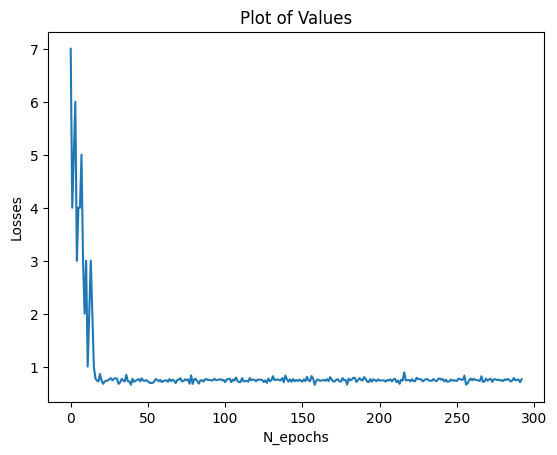

178


In [108]:
import optuna
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from  tqdm import tqdm
import json

# with open('user_4_songs.json', 'r') as file:
#     data_dict = json.load(file)
num_users = 1  # Change this to the number of users you have
user_embeddings = torch.eye(num_users)  # Create one-hot encoded tensors for users

embeddings = np.load("embedding_lyrics_total.npy")

loss_func  = nn.BCEWithLogitsLoss()

embeddings_tensor = torch.tensor(embeddings, dtype=torch.float32)
user_tensors_tensor = torch.tensor(user_embeddings, dtype=torch.float32)
labels_tensor = torch.tensor(labels,dtype=torch.float32).unsqueeze(1)
input_tensor = torch.cat((user_tensors_tensor.repeat(len(labels), 1), embeddings_tensor), dim=1)
input_size = input_tensor.shape[1]
losses = []
def training(model, train_loader, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):

            optimizer.zero_grad()
            output = model(data)
            loss = loss_func(output, target)
            loss.backward()
            optimizer.step()
            losses.append(loss)
            if len(losses) == 0:
                losses.append(loss)
            # print('Epoch {}, Batch {}, Loss {}'.format(epoch, batch_idx, loss.item()))

        return model
best_model = None
def testing(model, loss_function, test_data):
    global best_loss, best_model
    '''
    This function will test the given model on the given test_data
    it will return the accuracy and the test loss (given by loss_function)
    '''
    sum_loss = 0
    for batch_idx, (data, target) in enumerate(test_data):         
    
        pred = model(data)
        loss = loss_function(pred,target )
        sum_loss += loss.item()
    
    print(len(test_data))
    avg_loss = round(sum_loss / len(test_data), 2)
    if avg_loss < best_loss:
    
       best_loss = avg_loss
       best_model = model
        
    
    print("test loss:", best_model )
    return best_loss,best_model


        # print('Accuracy on test set: {}%'.format(100*correct/total))
accuracies = []
model = None
best_loss = 1000000
b_loss = 100000
def objective(trial):
    global model,b_loss
    hidden_dim = trial.suggest_int('hidden_dim', 50, 200)
    lr = trial.suggest_loguniform('lr', 1e-6, 1e-1)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    num_epochs = 100

    model = fs_model(input_size,hidden_dim,1)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    dataset = TensorDataset(input_tensor, labels_tensor)
    data_train, data_test = torch.utils.data.random_split(dataset, [211, 40])
    train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(data_test, batch_size=batch_size, shuffle=False)

    trained_model = training(model, train_loader, optimizer, num_epochs)
    test_loss,best_model = testing(trained_model,loss_func,test_loader)
    print("Test loss is ", test_loss)
    if test_loss < b_loss:
    
        b_loss = test_loss
        best_model = model
    
    # model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            # print(data, 'data')
            # print(output, 'output')
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    accuracies.append(accuracy)
    return accuracy



study = optuna.create_study(direction='maximize')


study.optimize(objective, n_trials=100)


best_params = study.best_params
best_accuracy = study.best_value

single_embedding = embeddings[0]
single_embedding = np.append(single_embedding, 1)
embeddings_tensor = torch.tensor(single_embedding, dtype=torch.float32)
# input_tensor = torch.cat((user_tensors_tensor.repeat(len(labels), 1), embeddings_tensor), dim=1)

# dataset = TensorDataset(input_tensor, labels_tensor)

# train_loader = DataLoader(dataset, batch_size=32, shuffle=True)



# embeddings_tensor = torch.tensor(embeddings, dtype=torch.float32)
# user_tensors_tensor = torch.tensor(user_tensors, dtype=torch.float32)
# labels_tensor = torch.tensor(labels, dtype=torch.float32)
# input_tensor = torch.cat((user_tensors_tensor.repeat(len(labels), 1), embeddings_tensor), dim=1)

# with torch.no_grad():
#     for data, target in train_loader:
#         model(data)
final_output = best_model(embeddings_tensor).item()


print(final_output)



print("Best parameters:", best_params)
print("Best validation accuracy:", best_accuracy)
# losses = [loss.detach().numpy() for loss in losses]
losses = [float(element) for element in losses]
print(losses)
plt.plot(losses)
plt.xlabel('N_epochs')
plt.ylabel('Losses')
plt.title('Plot of Values')
plt.show()
print(best_params["hidden_dim"])
new_model = fs_model(input_size,2000,output_dim=1)


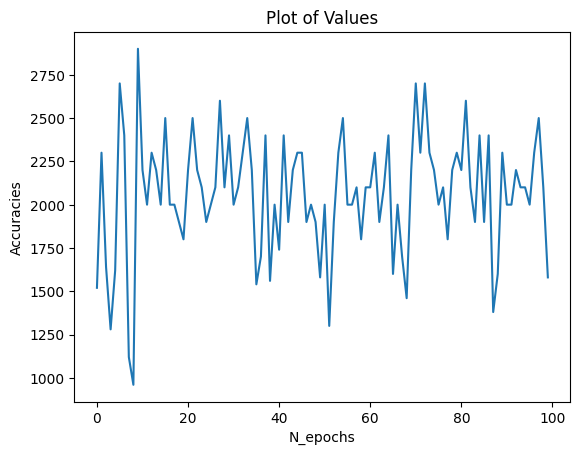

In [10]:
plt.plot(accuracies)
plt.xlabel('N_epochs')
plt.ylabel('Accuracies')
plt.title('Plot of Values')
plt.show()

In [121]:
songs_dict = {}
def get_lyrics(song_name, artist_name):
    try:
        dict_return = {}
        token = "3A0e7egqWm6omWk78xEe72UGXSUGNTiIVhTz81_Sq1pQc6ob_8642ZHCcmPC67WW"
        genius = lyricsgenius.Genius(token)
        
        artist = genius.search_song(song_name, artist_name)
        dict_return[song_name] = artist.lyrics
        return dict_return
    except:
        return "No lyrics found"
f_num = 5
h_num = 5
def get_user_input():
    list_return = []
    global f_num,h_num
    for i in range(f_num):
        try:
            f_input = input("Input your favorite song(include artists after comma)")
            f_list = f_input.split(",")
            songs_dict = get_lyrics(f_list[0], f_list[1])
            
            list_return.append(songs_dict)
        except:
            print("Song not found,try again")
            f_num+=1
        

            
        
        
    for i in range(h_num):
        try:

            h_input = input("Input your hated songs (include artists after comma): ")
            
            h_list = h_input.split(",")
            songs_dict = get_lyrics(h_list[0], h_list[1])
            list_return.append(songs_dict)
        except:
            print("Song not found,try again")
            h_num+=1
    return list_return
returned_list = get_user_input()

Searching for "Lights up" by  Harry Styles...
Done.
Searching for "Shake it up" by  Taylor Swift...
Done.
Searching for "Diamond" by  Rihanna...
Done.
Searching for "Baby" by  Justin Bieber...
Done.
Searching for "Swim" by  Chase Atlantic...
Done.
Song not found,try again
Searching for "The Albatross" by  Taylor Swift...
Done.
Searching for "Goosebumps" by  Travis Scott...
Done.
Searching for "Nonsense" by  Sabrina Carpenter...
Done.
Searching for "august" by  Taylor Swift...
Done.


In [45]:
from sentence_transformers import  SentenceTransformer
import os
class findEmbedding:
    def __init__(self,dictionary,name) -> None:
        self.model = SentenceTransformer('all-MiniLM-L6-v2')
        embeddings = self.computeEmbeddings(dictionary)

        PATH = os.path.join(f"{name}.npy")
        with open( PATH, "wb") as fp:
            np.save(fp, embeddings)

    def computeEmbeddings(self,dictionary):
        embeddings = []


        
        for song in dictionary:
            sentence = list(song.keys())
            sentence = song[sentence[0]]
            
            embeddings.append(self.model.encode(sentence))

                # Increment the file counter
                
        return np.array(embeddings)

In [48]:
findEmbedding(returned_list,"test")


In [71]:
from torch import optim
def few_shot_train():
    embeddings_few_shot = np.load("test.npy")
    print(embeddings_few_shot.shape)
    label_few_shot = [1,1,1,1,1,0,0,0,0,0]
    ones_column = torch.ones((1, 1))  # Create a column of ones
    # Create a dataset for user feedback
    dataset = [(embedding, label) for embedding, label in zip(embeddings_few_shot, label_few_shot)]
    # Fine-tune the pre-trained model on user feedback
    fine_tune_loader = DataLoader(dataset, batch_size=32, shuffle=True)
    fine_tune_epochs = 100  # Adjust the number of fine-tuning epochs as needed
    optimizer = optim.Adam(best_model.parameters(), lr=1)
    for epoch in range(fine_tune_epochs):
        for data, target in fine_tune_loader:
            optimizer.zero_grad()
            data = torch.tensor(data,dtype=torch.float32)
            embeddings_with_ones = torch.cat((data, ones_column), dim=1)
            target = torch.tensor(target,dtype=torch.float32)
            output = model(embeddings_with_ones)
            output = output.squeeze(1)
            loss = loss_func(output, target)
            loss.backward()
            optimizer.step()
    return model
    

# Evaluate the fine-tuned model
# test_loss, test_accuracy = testing(model, loss_func, test_loader)

In [116]:
test = {}

test["I wanna be yours"] = get_lyrics("Swim","Chase Atlantic")
findEmbedding(dictionary=test,name="test")

Searching for "Swim" by Chase Atlantic...
Done.
"Swim" by Chase Atlantic:
    53 ContributorsTranslationsEspañolSwim Lyrics[Verse 1]
    Yeah
    I bet you feel it now, baby
    Especially s...
I wanna be yours


In [124]:
import random
random.randint(1,54)
def search_songs(input_model):
    songs_found = {}
    r = random.randint(0,54)
    for filename in os.listdir("results"):
        
        with open(f"results/user_{r}_songs.json", 'r', encoding='utf-8', newline='') as file:
            data = json.load(file)
            for obj in data:
               song_title = obj["Title"]
               song_artist = obj["Artist"]
               
               dict_found = get_lyrics(song_title,song_artist)
               if dict_found == "No lyrics found":
                   continue
                
               dict_found =[dict_found]
               findEmbedding(dictionary=dict_found,name="test")
               embeddings = np.load("test.npy")
               embeddings = torch.tensor(embeddings)
               ones_column = torch.ones((1, 1))
               test_embeddings = torch.cat((embeddings, ones_column), dim=1)


               score = input_model(test_embeddings)
               score = score.item()

               if score>0.48:
                   l= dict_found[0]
                   return list(l.keys())[0]
                   
            else:
                continue
    return songs_found

In [142]:
import os
import faiss
import pandas as pd
from sentence_transformers import SentenceTransformer
from pprint import pprint
class recmmSystem:
    def __init__(self) -> None:
        self.model = SentenceTransformer('all-MiniLM-L6-v2')
        self.df = pd.read_csv("spotify_millsongdata.csv")
        PATH = os.path.join("embedding_lyrics_total.npy")
        embeddings = np.load(PATH)
        dimension = embeddings.shape[1]
        quantize = faiss.IndexFlatL2(dimension)
        self.index = faiss.IndexIVFFlat(quantize, dimension, 50)

        if not self.index.is_trained:
            self.index.train(embeddings)
        
        if self.index.is_trained:
            # let's add this 
            self.index.add(embeddings)

        print("Total Number of embeddings index {}".format(self.index.ntotal))
    
    def nearestNeighbour(self, query, k):
        # we can now search 
        queryEmbeddings = self.model.encode([query])
        D, I = self.index.search(queryEmbeddings, k)
        # let's get the index result 
        artist_songs = dict()
        allRelatable = self.df.iloc[I[0]]
        for index, rows in allRelatable.iterrows():
            artist_songs[rows["artist"]] = rows["song"]
        
        print("Query: ", query)
        pprint(artist_songs)


In [ ]:
system = recmmSystem()
system.nearestNeighbour(list(songs_dict.keys())[0])

WARNING clustering 251 points to 50 centroids: please provide at least 1950 training points


EVERYTHING TOGETHER

In [ ]:
def everything_together(songs_dict):
    if songs_dict is None:#if it is a premade
        songs_dict = get_user_input()
    
    findEmbedding(dictionary=songs_dict,name="test")
    t_model = few_shot_train()
    print("5 SONGS I LIKE")
    for i in returned_list[:5]:
         print(f"\n{list(i.keys())[0]}")
    print("5 SONGS I DO NOT LIKE")
    for i in returned_list[5:]:
        print(f"\n{list(i.keys())[0]}")
    print("Song that you need to listen next is",search_songs(t_model))

    
everything_together(None)
    

In [10]:
'import tkinter as tk


song_arr = []

shown = False

def song_list():
    if shown:
        shown = True
    else:
        shown = False
    
    if shown:
        song_list.config(text=f"{song_arr}!")
    else:
        song_list.config(text="")


def submit_song():
    song = entry.get()
    if song in song_arr:
        songs_2.config(text=f"{song} is already in list!")
    else:
        song_arr.append(song)
    if song:
        song_list.config(text=f"{song_arr}!")
    else:
       song_list.config(text="Input some songs")


root = tk.Tk()
root.title("Spotify Song Recommender")


entry = tk.Entry(root, width=30)
entry.pack(pady=10)

song_button = tk.Button(root, text="Submit song", command=submit_song)
song_button.pack()

list_button = tk.Button(root, text="Show song list", command=song_list)
list_button.pack()

song_list = tk.Label(root, text="")

songs = tk.Label(root, text="Songs:")
songs_2 = tk.Label(root, text="")
song_list = tk.Label(root, text="")

songs.pack()
songs_2.pack()
song_list.pack(pady=10)


root.mainloop()

Exception in Tkinter callback
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/tkinter/__init__.py", line 1921, in __call__
    return self.func(*args)
  File "/var/folders/_3/hpp2kxf54pndqxk7bcfbzl6w0000gn/T/ipykernel_69786/3149611433.py", line 9, in song_list
    if shown:
UnboundLocalError: local variable 'shown' referenced before assignment
Exception in Tkinter callback
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/tkinter/__init__.py", line 1921, in __call__
    return self.func(*args)
  File "/var/folders/_3/hpp2kxf54pndqxk7bcfbzl6w0000gn/T/ipykernel_69786/3149611433.py", line 9, in song_list
    if shown:
UnboundLocalError: local variable 'shown' referenced before assignment
Exception in Tkinter callback
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/tkinter/__init__.py", line 1921, in __call__
  

: 

In [22]:


print(embeddings)

[[-0.06669568 -0.09863818  0.04980293 ... -0.00151163  0.05756469
  -0.05387075]
 [-0.06669568 -0.09863818  0.04980293 ... -0.00151163  0.05756469
  -0.05387075]
 [-0.06669568 -0.09863818  0.04980293 ... -0.00151163  0.05756469
  -0.05387075]
 ...
 [-0.06669568 -0.09863818  0.04980293 ... -0.00151163  0.05756469
  -0.05387075]
 [-0.06669568 -0.09863818  0.04980293 ... -0.00151163  0.05756469
  -0.05387075]
 [-0.06669568 -0.09863818  0.04980293 ... -0.00151163  0.05756469
  -0.05387075]]
